In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling 
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# memory management
import gc

In [2]:
# Read in data
train_bureau = pd.read_csv('downloads/train_bureau_raw.csv/train_bureau_raw.csv', nrows = 1000)
test_bureau = pd.read_csv('downloads/test_bureau_raw.csv/test_bureau_raw.csv', nrows = 1000)

train_previous = pd.read_csv('downloads/train_previous_raw.csv/train_previous_raw.csv', nrows = 1000)
test_previous = pd.read_csv('downloads/test_previous_raw.csv/test_previous_raw.csv', nrows = 1000)

# All columns in dataframes
bureau_columns = list(train_bureau.columns)
previous_columns = list(train_previous.columns)

In [3]:
# Bureau only features
bureau_features = list(set(bureau_columns) - set(previous_columns))

# Previous only features
previous_features = list(set(previous_columns) - set(bureau_columns))

# Original features will be in both datasets
original_features = list(set(previous_columns) & set(bureau_columns))

print('There are %d original features.' % len(original_features))
print('There are %d bureau and bureau balance features.' % len(bureau_features))
print('There are %d previous Home Credit loan features.' % len(previous_features))

There are 123 original features.
There are 179 bureau and bureau balance features.
There are 1043 previous Home Credit loan features.


In [4]:
train_labels = train_bureau['TARGET']
previous_features.append('SK_ID_CURR')

train_ids = train_bureau['SK_ID_CURR']
test_ids = test_bureau['SK_ID_CURR']

# Merge the dataframes avoiding duplicating columns by subsetting train_previous

train = train_bureau.merge(train_previous[previous_features],on='SK_ID_CURR')
test = test_bureau.merge(test_previous[previous_features],on = 'SK_ID_CURR')

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (1000, 1345)
Testing shape:  (1000, 1344)


In [5]:
# One hot encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (1000, 1447)
Testing shape:  (1000, 1447)


In [6]:
cols_with_id = [x for x in train.columns if 'SK_ID_CURR' in x]
cols_with_bureau_id = [x for x in train.columns if 'SK_ID_BUREAU' in x]
cols_with_previous_id = [x for x in train.columns if 'SK_ID_PREV' in x]
print('There are %d columns that contain SK_ID_CURR' % len(cols_with_id))
print('There are %d columns that contain SK_ID_BUREAU' % len(cols_with_bureau_id))
print('There are %d columns that contain SK_ID_PREV' % len(cols_with_previous_id))

train = train.drop(columns = cols_with_id)
test = test.drop(columns = cols_with_id)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

There are 49 columns that contain SK_ID_CURR
There are 0 columns that contain SK_ID_BUREAU
There are 0 columns that contain SK_ID_PREV
Training shape:  (1000, 1398)
Testing shape:  (1000, 1398)


In [7]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
CNT_CHILDREN,1.000000,0.055960,0.036836,0.055732,0.035851,0.060210,0.303782,0.218535,0.211766,0.036960,...,0.096914,0.064817,0.024544,0.019465,0.005586,0.030986,0.001443,0.027967,0.004500,0.020465
AMT_INCOME_TOTAL,0.055960,1.000000,0.429317,0.491143,0.439981,0.184339,0.088743,0.208663,0.130682,0.045634,...,0.033574,0.064520,0.020186,0.058210,0.060465,0.080291,0.000218,0.043426,0.107476,0.030645
AMT_CREDIT,0.036836,0.429317,1.000000,0.797209,0.986046,0.074287,0.065100,0.116515,0.027876,0.022994,...,0.005136,0.011202,0.007313,0.060005,0.009795,0.098314,0.018123,0.009507,0.075595,0.009483
AMT_ANNUITY,0.055732,0.491143,0.797209,1.000000,0.799121,0.106685,0.019480,0.139220,0.059163,0.024020,...,0.011107,0.022890,0.017907,0.084270,0.022107,0.133969,0.036801,0.032497,0.098291,0.036308
AMT_GOODS_PRICE,0.035851,0.439981,0.986046,0.799121,1.000000,0.073531,0.058535,0.115613,0.034500,0.030878,...,0.002397,0.020737,0.000716,0.069845,0.014077,0.094081,0.012866,0.019114,0.082543,0.000395


In [12]:
val = np.ones(corr_matrix.shape)
val.astype(np.bool)
val

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [10]:
corr_matrix.shape

(1398, 1398)

In [11]:
val.shape

(1398, 1398)

In [13]:
a = np.array([[1, 2, 3], [4, 5, 6]])
  
print(a)
  
print ('Indices of elements <4')
  
b = np.where(a<4)
print(b)

[[1 2 3]
 [4 5 6]]
Indices of elements <4
(array([0, 0, 0], dtype=int64), array([0, 1, 2], dtype=int64))


In [19]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
CNT_CHILDREN,NaN,0.05596,0.036836,0.055732,0.035851,0.060210,0.303782,0.218535,0.211766,0.036960,...,0.096914,0.064817,0.024544,0.019465,0.005586,0.030986,0.001443,0.027967,0.004500,0.020465
AMT_INCOME_TOTAL,NaN,NaN,0.429317,0.491143,0.439981,0.184339,0.088743,0.208663,0.130682,0.045634,...,0.033574,0.064520,0.020186,0.058210,0.060465,0.080291,0.000218,0.043426,0.107476,0.030645
AMT_CREDIT,NaN,NaN,NaN,0.797209,0.986046,0.074287,0.065100,0.116515,0.027876,0.022994,...,0.005136,0.011202,0.007313,0.060005,0.009795,0.098314,0.018123,0.009507,0.075595,0.009483
AMT_ANNUITY,NaN,NaN,NaN,NaN,0.799121,0.106685,0.019480,0.139220,0.059163,0.024020,...,0.011107,0.022890,0.017907,0.084270,0.022107,0.133969,0.036801,0.032497,0.098291,0.036308
AMT_GOODS_PRICE,NaN,NaN,NaN,NaN,NaN,0.073531,0.058535,0.115613,0.034500,0.030878,...,0.002397,0.020737,0.000716,0.069845,0.014077,0.094081,0.012866,0.019114,0.082543,0.000395


In [20]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 580 columns to remove.


In [21]:
train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (1000, 818)
Testing shape:  (1000, 818)


In [22]:
train = pd.read_csv('downloads/m_train_combined.csv/m_train_combined.csv')
test = pd.read_csv('downloads/m_test_combined.csv/m_test_combined.csv')

In [23]:
print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 865)
Testing set full shape:  (48744, 864)


In [26]:
train_missing = (train.isnull().sum()/len(train)).sort_values(ascending=False)
train_missing.head()

client_credit_AMT_PAYMENT_CURRENT_min_min            0.801438
client_credit_AMT_PAYMENT_CURRENT_mean_max           0.801438
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_mean    0.801178
client_credit_AMT_DRAWINGS_OTHER_CURRENT_mean_min    0.801178
client_credit_AMT_DRAWINGS_POS_CURRENT_mean_mean     0.801178
dtype: float64

In [27]:
test_missing = (test.isnull().sum()/len(test)).sort_values(ascending=False)
test_missing.head()

client_credit_CNT_DRAWINGS_OTHER_CURRENT_mean_max    0.773223
client_credit_AMT_DRAWINGS_OTHER_CURRENT_max_max     0.773223
client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_mean     0.773223
client_credit_AMT_DRAWINGS_POS_CURRENT_mean_mean     0.773223
client_credit_AMT_DRAWINGS_POS_CURRENT_min_min       0.773223
dtype: float64

In [28]:
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

There are 19 columns with more than 75% missing values


In [30]:
# Need to save the labels because aligning will remove this column
train_labels = train["TARGET"]
train_ids = train['SK_ID_CURR']
test_ids = test['SK_ID_CURR']

train = pd.get_dummies(train.drop(columns=all_missing))
test = pd.get_dummies(test.drop(columns=all_missing))

train, test = train.align(test,join='inner',axis=1)

print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 845)
Testing set full shape:  (48744, 845)


In [31]:
train = train.drop(columns = ['SK_ID_CURR'])
test = test.drop(columns = ['SK_ID_CURR'])

In [34]:
import re
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [35]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [36]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

[200]	valid_0's auc: 0.780255	valid_0's binary_logloss: 0.50914
[200]	valid_0's auc: 0.784117	valid_0's binary_logloss: 0.508275


In [40]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False,inplace=True)

feature_importances.head()

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [42]:
feature_importances.reset_index(inplace=True)

In [44]:
feature_importances.head()

,index,feature,importance
0,24,EXT_SOURCE_1,151.5
1,25,EXT_SOURCE_2,132.0
2,26,EXT_SOURCE_3,121.0
3,368,client_installments_AMT_PAYMENT_min_sum,115.5
4,5,DAYS_BIRTH,95.0


In [45]:
feature_importances = feature_importances.drop(columns = ['index'])
feature_importances.head()

,feature,importance
0,EXT_SOURCE_1,151.5
1,EXT_SOURCE_2,132.0
2,EXT_SOURCE_3,121.0
3,client_installments_AMT_PAYMENT_min_sum,115.5
4,DAYS_BIRTH,95.0


In [46]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 307 features with 0.0 importance


,feature,importance
839,client_cash_NAME_CONTRACT_STATUS_Completed_cou...,0.0
840,previous_loans_CHANNEL_TYPE_Cardealer_count,0.0
841,client_credit_NAME_CONTRACT_STATUS_Signed_coun...,0.0
842,previous_loans_NAME_GOODS_CATEGORY_Weapon_count,0.0
843,EMERGENCYSTATE_MODE_Yes,0.0


In [47]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

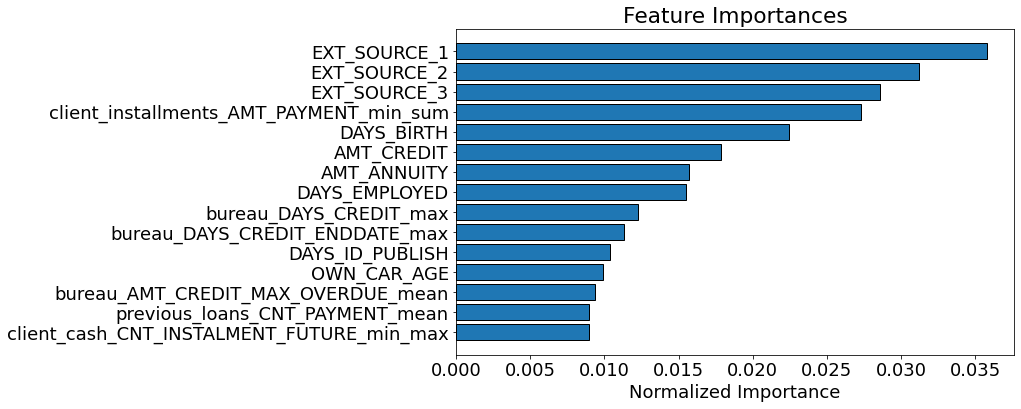

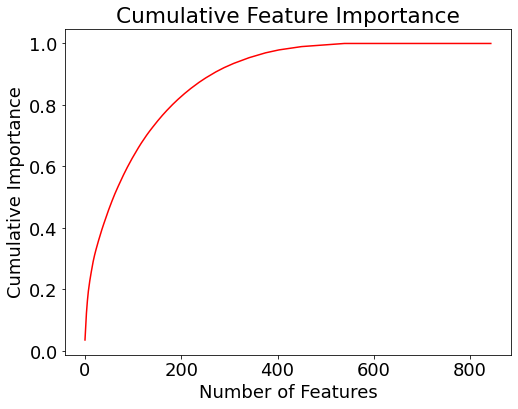

265 features required for 0.90 of cumulative importance


In [48]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [49]:
train = train.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 537)
Testing shape:  (48744, 537)


In [50]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [51]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train, train_labels)

[200]	valid_0's auc: 0.781856	valid_0's binary_logloss: 0.508914
[200]	valid_0's auc: 0.78343	valid_0's binary_logloss: 0.508466

There are 0 features with 0.0 importance


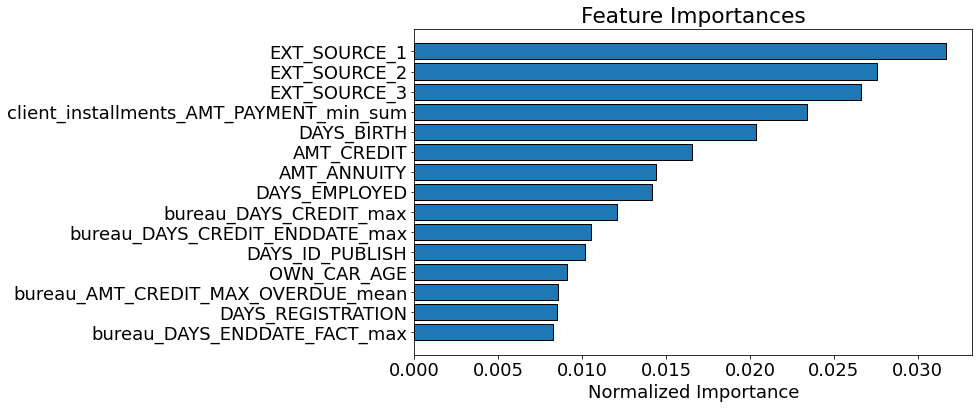

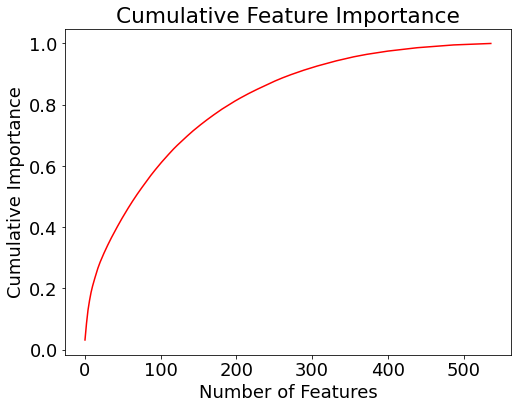

345 features required for 0.95 of cumulative importance


In [52]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

In [53]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

In [54]:
train_small['TARGET'] = train_labels
train_small['SK_ID_CURR'] = train_ids
test_small['SK_ID_CURR'] = test_ids

train_small.to_csv('m_train_small.csv', index = False)
test_small.to_csv('m_test_small.csv', index = False)

In [55]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [56]:
train['TARGET'] = train_labels
train['SK_ID_CURR'] = train_ids
test['SK_ID_CURR'] = test_ids

submission, feature_importances, metrics = model(train, test)

Training Data Shape:  (307511, 537)
Testing Data Shape:  (48744, 537)
[200]	train's auc: 0.829284	train's binary_logloss: 0.516229	valid's auc: 0.781594	valid's binary_logloss: 0.536872
[400]	train's auc: 0.866788	train's binary_logloss: 0.47339	valid's auc: 0.783001	valid's binary_logloss: 0.509547
[200]	train's auc: 0.828385	train's binary_logloss: 0.517185	valid's auc: 0.784864	valid's binary_logloss: 0.537686
[400]	train's auc: 0.866077	train's binary_logloss: 0.474422	valid's auc: 0.786333	valid's binary_logloss: 0.510922
[200]	train's auc: 0.830329	train's binary_logloss: 0.514807	valid's auc: 0.776761	valid's binary_logloss: 0.536163
[400]	train's auc: 0.86794	train's binary_logloss: 0.47205	valid's auc: 0.779561	valid's binary_logloss: 0.508919
[200]	train's auc: 0.828746	train's binary_logloss: 0.517077	valid's auc: 0.783903	valid's binary_logloss: 0.535646
[400]	train's auc: 0.86621	train's binary_logloss: 0.474358	valid's auc: 0.785101	valid's binary_logloss: 0.507937
[200]	

In [57]:
metrics

,fold,train,valid
0,0,0.859618,0.783262
1,1,0.848799,0.786831
2,2,0.869774,0.779593
3,3,0.872075,0.785427
4,4,0.892779,0.786966
5,overall,0.868609,0.784341


In [58]:
submission.to_csv('selected_features_submission.csv', index = False)

In [59]:
submission_small, feature_importances_small, metrics_small = model(train_small, test_small)

Training Data Shape:  (307511, 344)
Testing Data Shape:  (48744, 344)
[200]	train's auc: 0.828911	train's binary_logloss: 0.516513	valid's auc: 0.781681	valid's binary_logloss: 0.536746
[400]	train's auc: 0.866674	train's binary_logloss: 0.473629	valid's auc: 0.783029	valid's binary_logloss: 0.510049
[200]	train's auc: 0.82822	train's binary_logloss: 0.517364	valid's auc: 0.784179	valid's binary_logloss: 0.537622
[400]	train's auc: 0.866388	train's binary_logloss: 0.474025	valid's auc: 0.786263	valid's binary_logloss: 0.510385
[200]	train's auc: 0.829798	train's binary_logloss: 0.515278	valid's auc: 0.777394	valid's binary_logloss: 0.53658
[400]	train's auc: 0.867496	train's binary_logloss: 0.472305	valid's auc: 0.779657	valid's binary_logloss: 0.509155
[200]	train's auc: 0.828768	train's binary_logloss: 0.516847	valid's auc: 0.784226	valid's binary_logloss: 0.535698
[200]	train's auc: 0.828465	train's binary_logloss: 0.517109	valid's auc: 0.783432	valid's binary_logloss: 0.535378
[400

In [60]:
metrics_small

,fold,train,valid
0,0,0.871782,0.783177
1,1,0.868122,0.786353
2,2,0.876543,0.779945
3,3,0.840193,0.785448
4,4,0.884512,0.786580
5,overall,0.868230,0.784152


In [61]:
submission_small.to_csv('selected_features_small_submission.csv', index = False)

In [62]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Make sure to drop the ids and target
train = train.drop(columns = ['SK_ID_CURR', 'TARGET'])
test = test.drop(columns = ['SK_ID_CURR'])

# Make a pipeline with imputation and pca
pipeline = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')),
             ('pca', PCA())])

# Fit and transform on the training data
train_pca = pipeline.fit_transform(train)

# transform the testing data
test_pca = pipeline.transform(test)

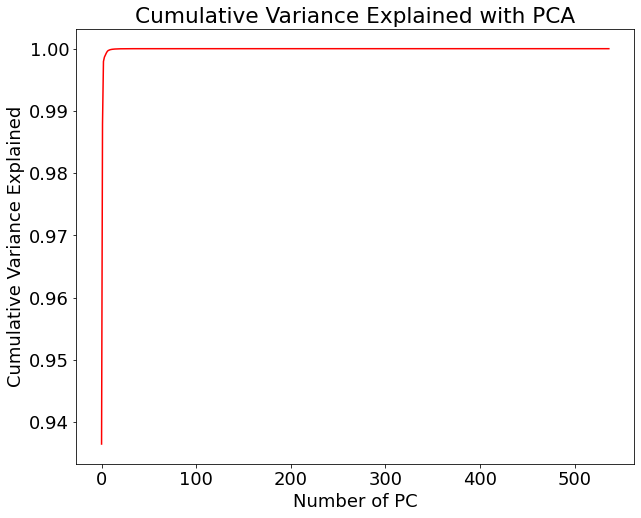

In [63]:
# Extract the pca object
pca = pipeline.named_steps['pca']

# Plot the cumulative variance explained

plt.figure(figsize = (10, 8))
plt.plot(list(range(train.shape[1])), np.cumsum(pca.explained_variance_ratio_), 'r-')
plt.xlabel('Number of PC'); plt.ylabel('Cumulative Variance Explained');
plt.title('Cumulative Variance Explained with PCA');

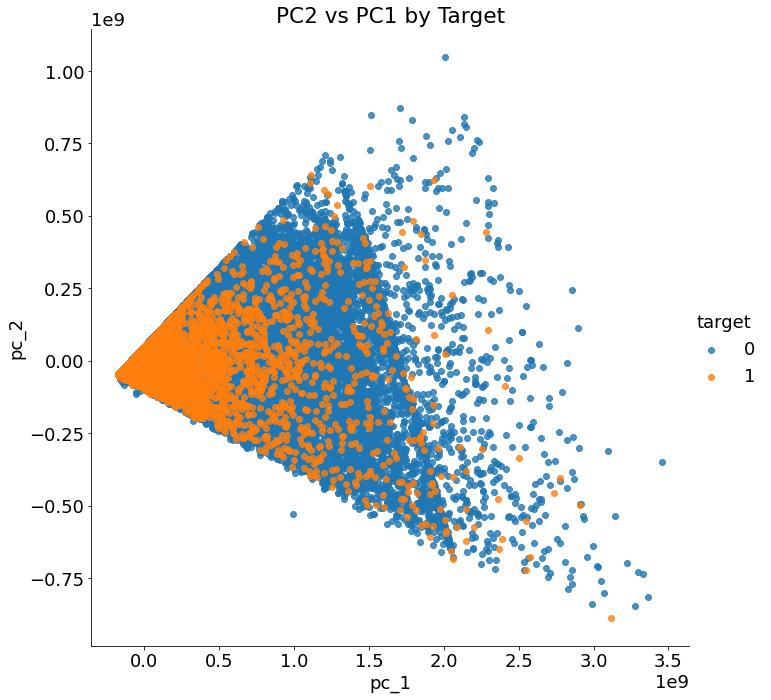

In [64]:
# Dataframe of pca results
pca_df = pd.DataFrame({'pc_1': train_pca[:, 0], 'pc_2': train_pca[:, 1], 'target': train_labels})

# Plot pc2 vs pc1 colored by target
sns.lmplot('pc_1', 'pc_2', data = pca_df, hue = 'target', fit_reg=False, size = 10)
plt.title('PC2 vs PC1 by Target');

In [65]:
print('2 principal components account for {:.4f}% of the variance.'.format(100 * np.sum(pca.explained_variance_ratio_[:2])))

2 principal components account for 98.7933% of the variance.
